### **Object detection for artefacts in documents**

In this notebook, we will explore how to use a popular object detection architecture, [Faster-RCNN](https://arxiv.org/abs/1506.01497), to detect QR codes, bar codes, logos and ID pictures in documents.

Faster R-CNN is an end-to-end architecture, which leverages a dedicated module to generate region proposals (considerably more efficient than traditional algorithms like Selective Search). The features of those localization candidates are then extracted by an ROI Pooling layer to produce fixed-size feature maps from each candidate. The network can accurately and quickly predict the locations of different objects. Please refer to [Faster R-CNN Explained for Object Detection Tasks](https://blog.paperspace.com/faster-r-cnn-explained-object-detection/) for a quick introduction.


## Setup
Installing requirements

In [2]:
!pip3 install git+https://github.com/mindee/doctr.git

  Cloning https://github.com/mindee/doctr.git to /tmp/pip-req-build-32qc9zym
  Running command git clone -q https://github.com/mindee/doctr.git /tmp/pip-req-build-32qc9zym
     |████████████████████████████████| 8.7 MB 3.9 MB/s 
     |████████████████████████████████| 603 kB 48.9 MB/s 
     |████████████████████████████████| 88 kB 7.8 MB/s 
     |████████████████████████████████| 365 kB 45.9 MB/s 
     |████████████████████████████████| 235 kB 51.8 MB/s 
     |████████████████████████████████| 3.1 MB 33.4 MB/s 
     |████████████████████████████████| 893 kB 42.6 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 88 kB 7.6 MB/s 
     |████████████████████████████████| 2.0 MB 40.6 MB/s 
  Created wheel for python-doctr: filename=python_doctr-0.5.0a0-py3-none-any.whl size=190179 sha256=3d0cd88ca996cced56c4da7d84fdd1b8edfafe8190b74b3aa479231d7f30ace3
  Stored in directory: /tmp/pip-ephem-wheel-cache-b2i2drwq/wheels/d0/0b/ff/7a8340c45668115

## Inference utilities
Import all dependencies at once 

In [4]:
import os

os.environ['USE_TORCH'] = '1'

import argparse
import logging
import numpy as np

import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch

from doctr.io.image import read_img_as_tensor
from doctr.models import obj_detection

# Path to input image file
!wget https://images.sampletemplates.com/wp-content/uploads/2018/04/Car-Parking-Receipt-Template.jpg

# Detected classes
CLASSES = ["__background__", "QR Code", "Barcode", "Logo", "Photo"]
# Color map for each class
CM = [(255, 255, 255), (0, 0, 150), (0, 0, 0), (0, 150, 0), (150, 0, 0)]

--2021-12-25 09:59:51--  https://images.sampletemplates.com/wp-content/uploads/2018/04/Car-Parking-Receipt-Template.jpg
Resolving images.sampletemplates.com (images.sampletemplates.com)... 151.101.2.133, 151.101.66.133, 151.101.130.133, ...
Connecting to images.sampletemplates.com (images.sampletemplates.com)|151.101.2.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68765 (67K) [image/jpeg]
Saving to: ‘Car-Parking-Receipt-Template.jpg.2’

Car-Parking-Receipt 100%[===================>]  67.15K  --.-KB/s    in 0.01s   

2021-12-25 09:59:51 (4.50 MB/s) - ‘Car-Parking-Receipt-Template.jpg.2’ saved [68765/68765]



Everything you need to plot your model's predictions

In [6]:
# Plots the predictions on the input image
def plot_predictions(image, boxes, labels):
    for box, label in zip(boxes, labels):
        # Bounding box around artefacts
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]),
                      CM[label], 2)
        text_size, _ = cv2.getTextSize(CLASSES[label], cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
        text_w, text_h = text_size
        # Filled rectangle above bounding box
        cv2.rectangle(image, (box[0], box[1]), (box[0] + text_w, box[1] - text_h),
                      CM[label], -1)
        # Text bearing the name of the artefact detected
        cv2.putText(image, CLASSES[label], (int(box[0]), int(box[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    figure(figsize=(10, 8), dpi=90)
    plt.axis('off')
    plt.imshow(image)
    plt.show()


## Visualizing your detections
`img_path: str` >> path to image file


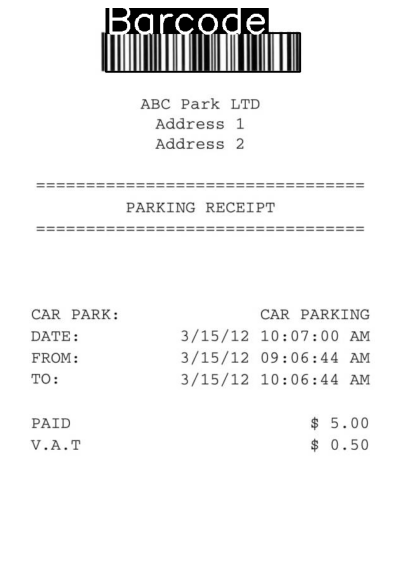

In [9]:
# Initializing the model fasterrcnn_mobilenet_v3_large_fpn
model = obj_detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, num_classes=5).eval()

img_path = "Car-Parking-Receipt-Template.jpg"
# Reading the input image
img = read_img_as_tensor(img_path).unsqueeze(0)

if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()

with torch.no_grad():
    pred = model(img)

labels = pred[0]['labels'].detach().cpu().numpy()
labels = labels.round().astype(int)
boxes = pred[0]['boxes'].detach().cpu().numpy()
boxes = boxes.round().astype(int)
img = (255 * img.cpu().squeeze(0).permute(1, 2, 0).numpy().copy()).round().astype(np.uint8)
plot_predictions(img, boxes, labels)